# Compare

Compare WSRA, SWIFT, and Wave Glider wave measurements during ATOMIC.

In [1]:
import glob
import re
from datetime import datetime
from typing import Tuple

import cartopy
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywsra
import scipy
import xarray as xr
from IPython import get_ipython
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from sharedfunctions import configure_figures, read_stored_variable

## Setup

Read stored variables from `io.pynb` and `calculate.ipnyb`.  Configure matplotlib figures using shared parameters.

Stored 'atomic_wsra' (Dataset)
Stored 'atomic_swifts' (dict)
Stored 'atomic_wave_gliders' (dict)
Stored 'atomic_ship' (Dataset)


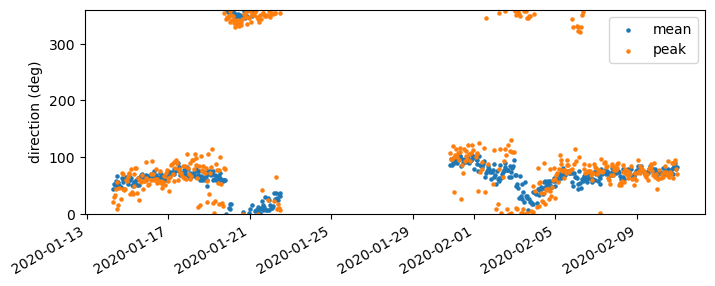

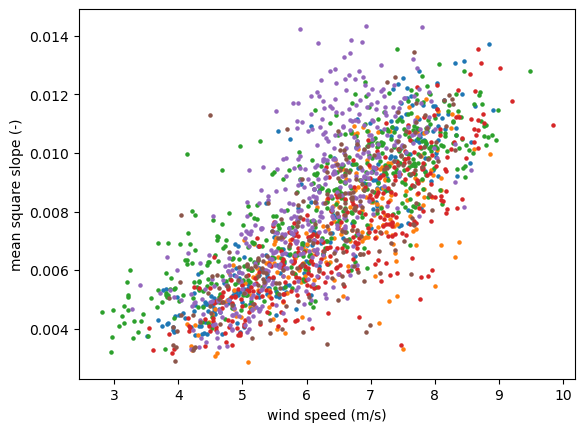

/opt/homebrew/Caskroom/miniconda/base/envs/PyWSRA/lib/python3.10/site-packages/xarray/core/accessor_dt.py:132: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [2]:
%run 'calculate.ipynb'
%run -i sharedfunctions.py
atomic_wsra = read_stored_variable('atomic_wsra')
atomic_swifts = read_stored_variable('atomic_swifts')
atomic_wave_gliders = read_stored_variable('atomic_wave_gliders')

configure_figures()

## Overview

### WSRA flight path

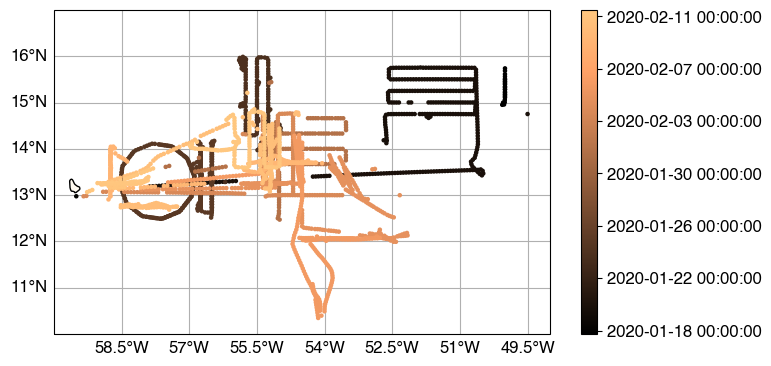

In [3]:
PROJECTION = cartopy.crs.PlateCarree()
IMAGE_RESOLUTION = 400

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=PROJECTION)

atomic_wsra.wsra.chart.ocean_color = 'white'
atomic_wsra.wsra.chart.land_color = 'floralwhite'

ax = atomic_wsra.wsra.plot(
    ax=ax,
    extent=(-60, -49, 10, 17),
    plot_best_track=False,
    column='timestamp',
    cmap='copper',
    label='WSRA',
    legend=True,
    legend_kwds={
     'shrink': 0.7,
    }
)
cax = ax.get_figure().axes[-1]
date_ticks = pd.date_range(start=atomic_wsra['time'][0].dt.ceil('D').values,
                           end=atomic_wsra['time'][-1].dt.floor('D').values,
                           freq='4D')
_ = cax.set_yticks(pd.to_numeric(date_ticks), labels=date_ticks)

# plt.savefig('wsra_hurricane_earl_time_tracks.png', dpi=IMAGE_RESOLUTION)

### WSRA flight metadata

Plot the WSRA flight metadata (altitude, roll, and ground speed).

<GeoAxes: >

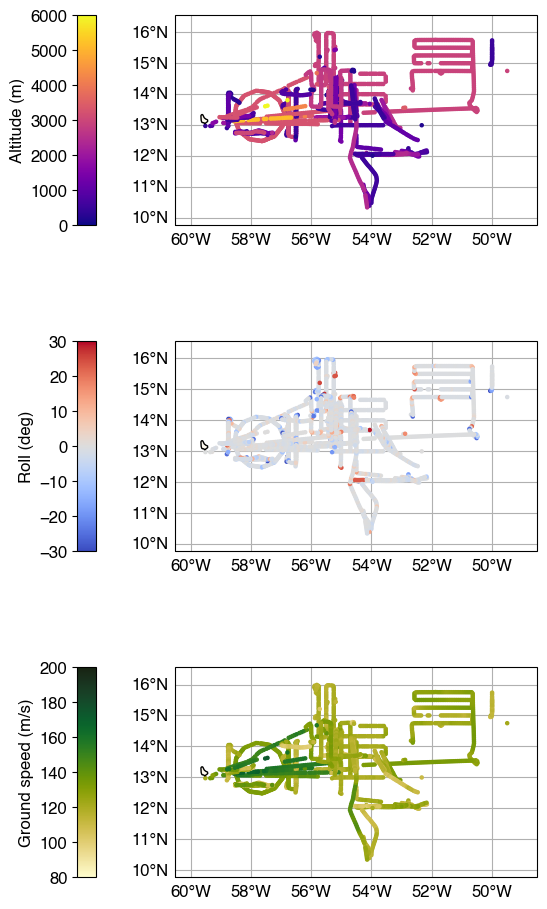

In [4]:
PROJECTION = cartopy.crs.PlateCarree()
IMAGE_RESOLUTION = 400

fig = plt.figure(figsize=(6, 12))

# Plot altitude
ax = fig.add_subplot(3, 1, 1, projection=PROJECTION)
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", axes_class=mpl.axes.Axes)
cmap = mpl.cm.plasma  # cmocean.cm.deep_r
norm = mpl.colors.Normalize(vmin=0, vmax=6000)
atomic_wsra.wsra.plot(
    column='platform_radar_altitude',  # 'ymd'
    plot_best_track=False,
    legend=True,
    cmap=cmap,
    norm=norm,
    ax=ax,
    cax=cax,
    legend_kwds={
        "label": "Altitude (m)",
        "orientation": "vertical",
        "location": "left",
    }
)

# Plot roll
ax = fig.add_subplot(3, 1, 2, projection=PROJECTION)
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", axes_class=mpl.axes.Axes)
cmap = mpl.cm.coolwarm
norm = mpl.colors.CenteredNorm(halfrange=30)
atomic_wsra.wsra.plot(
    column='wsra_computed_roll',  # 'ymd'
    plot_best_track=False,
    legend=True,
    cmap=cmap,
    norm=norm,
    ax=ax,
    cax=cax,
    legend_kwds={
        "label": "Roll (deg)",
        "orientation": "vertical",
        "location": "left",
    }
)

# Plot ground speed
ax = fig.add_subplot(3, 1, 3, projection=PROJECTION)
divider = make_axes_locatable(ax)
cax = divider.append_axes("left", size="5%", axes_class=mpl.axes.Axes)
cmap = cmocean.cm.speed
norm = mpl.colors.Normalize(vmin=80, vmax=200)
atomic_wsra.wsra.plot(
    column='platform_speed_wrt_ground',  # 'ymd'
    plot_best_track=False,
    legend=True,
    cmap=cmap,
    norm=norm,
    ax=ax,
    cax=cax,
    legend_kwds={
        "label": "Ground speed (m/s)",
        "orientation": "vertical",
        "location": "left",
    }
)

# fig.savefig(f'WSRA_flight_parameters.{IMAGE_FILE_TYPE}',
#             format=IMAGE_FILE_TYPE,
#             dpi=IMAGE_RESOLUTION)

### WSRA masking
Create a trajectory mask and overwrite the original data.  Use the limits specified in Pincus et al. (2021).

In [5]:
atomic_wsra.wsra.create_trajectory_mask(altitude_limits=(500, 4000),
                                        roll_limit=3)
atomic_wsra = atomic_wsra.wsra.mask()

Re-plot the masked trajectory

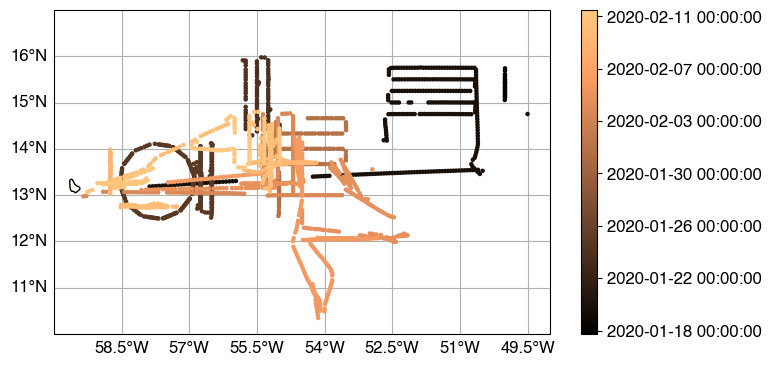

In [6]:
PROJECTION = cartopy.crs.PlateCarree()
IMAGE_RESOLUTION = 400

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=PROJECTION)

atomic_wsra.wsra.chart.ocean_color = 'white'
atomic_wsra.wsra.chart.land_color = 'floralwhite'

ax = atomic_wsra.wsra.plot(
    ax=ax,
    extent=(-60, -49, 10, 17),
    plot_best_track=False,
    column='timestamp',
    cmap='copper',
    label='WSRA',
    legend=True,
    legend_kwds={
     'shrink': 0.7,
    }
)
cax = ax.get_figure().axes[-1]
date_ticks = pd.date_range(start=atomic_wsra['time'][0].dt.ceil('D').values,
                           end=atomic_wsra['time'][-1].dt.floor('D').values,
                           freq='4D')
_ = cax.set_yticks(pd.to_numeric(date_ticks), labels=date_ticks)

# fig.savefig(f'WSRA_flight_path_masked.{IMAGE_FILE_TYPE}',
#             format=IMAGE_FILE_TYPE,
#             dpi=IMAGE_RESOLUTION)


### WSRA, SWIFT, and Wave Glider paths

Text(0.5, 1.0, 'ATOMIC WSRA flight path and SWIFT/Wave Glider drift tracks')

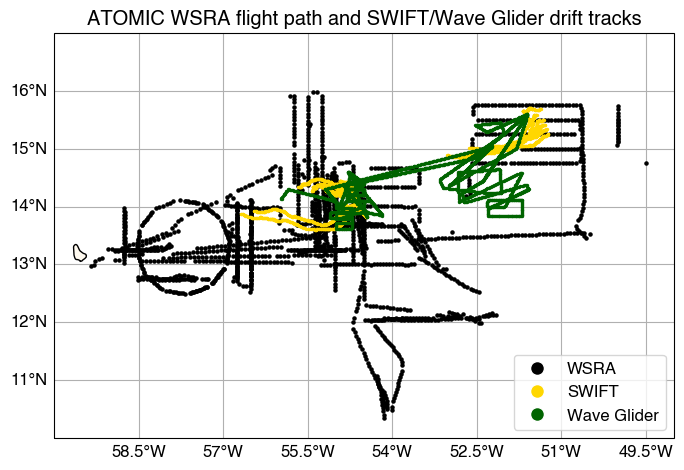

In [7]:
PROJECTION = cartopy.crs.PlateCarree()
IMAGE_RESOLUTION = 400

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection=PROJECTION)

atomic_wsra.wsra.chart.ocean_color = 'white'
atomic_wsra.wsra.chart.land_color = 'floralwhite'

atomic_wsra.wsra.plot(
    plot_best_track=False,
    extent=(-60, -49, 10, 17),
    ax=ax,
    label='WSRA'
)

for swift_id, swift_ds in atomic_swifts.items():
    ax.scatter(
        swift_ds['lon'],
        swift_ds['lat'],
        # c=swift_ds['ymd'].values,
        color='gold',
        s=2,
        label='SWIFT'
    )

for wave_glider_id, wave_glider_ds in atomic_wave_gliders.items():
    ax.scatter(
        wave_glider_ds['lon'],
        wave_glider_ds['lat'],
        s=2,
        color='darkgreen',
        label='Wave glider'
    )

legend_elements = [Line2D([0], [0], marker='o', color='w', label='WSRA',
                        markerfacecolor='k', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='SWIFT',
                        markerfacecolor='gold', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Wave Glider',
                        markerfacecolor='darkgreen', markersize=10)]

ax.legend(handles=legend_elements, loc='lower right')
ax.set_title('ATOMIC WSRA flight path and SWIFT/Wave Glider drift tracks')

# fig.savefig(f'ATOMIC_flight_and_drift_tracks.{IMAGE_FILE_TYPE}',
#             format=IMAGE_FILE_TYPE,
#             dpi=IMAGE_RESOLUTION)

## Colocation

In [8]:
def great_circle_pairwise(
    longitude_a: np.ndarray,
    latitude_a: np.ndarray,
    longitude_b: np.ndarray,
    latitude_b: np.ndarray,
    earth_radius: float = 6378.137,
    mod_bearing: bool = True
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Computes the great circle distance (km) and true fore bearing (deg) between
    pairs of observations in input arrays `longitude_a` and `longitude_b` and
    `latitude_a` and `latitude_b`.

    For two longitude and latitude pairs, the great circle distance is the
    shortest distance between the two points along the Earth's surface. This
    distance is calculated using the Haversine formula. The instances in
    `longitude_a` and `latitude_a` are designated as point `a`; the instances
    in `longitude_b` and `latitude_b` then form point `b`. The true fore
    bearing is the bearing, measured from true north, of `b` as seen from `a`.

    Note:
        When given `latitude_a/b` and `longitude_a/b` of shape (n,), n > 1,
        the great circle distance and fore bearing will be calculated between
        `a` and `b` entries such that the returned arrays will be of shape
        (n,). To compute the great circle distance and bearings between
        adjacent coordinates of single longitude and latitude arrays (i.e.,
        along a trajectory), use `great_circle_pathwise`.

    Args:
        longitude_a (np.array): of shape (n,) in units of decimal degrees
        latitude (np.array): of shape (n,) in units of decimal degrees
        earth_radius (float, optional): earth's radius in units of km. Defaults to 6378.137 km (WGS-84)
        mod_bearing (bool, optional): return bearings modulo 360 deg. Defaults to True.

    Returns:
        Tuple[np.array, np.array]: great circle distances (in km) and true fore
        bearings between adjacent longitude and latitude pairs; shape (n,)

    Example: A trajectory along the Earth's equator.
    ```
    >> #TODO:
    ```
    """
    # Convert decimal degrees to radians
    longitude_a_rad, latitude_a_rad = map(np.radians, [longitude_a, latitude_a])
    longitude_b_rad, latitude_b_rad = map(np.radians, [longitude_b, latitude_b])

    # Difference longitude and latitude
    longitude_difference = longitude_b_rad - longitude_a_rad
    latitude_difference = latitude_b_rad - latitude_a_rad

    # Haversine formula
    a_1 = np.sin(latitude_difference / 2) ** 2
    a_2 = np.cos(latitude_a_rad)
    a_3 = np.cos(latitude_b_rad)
    a_4 = np.sin(longitude_difference / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a_1 + a_2 * a_3 * a_4))
    distance_km = earth_radius * c

    # True bearing
    bearing_num = np.cos(latitude_b_rad) * np.sin(-longitude_difference)
    bearing_den_1 = np.cos(latitude_a_rad) * np.sin(latitude_b_rad)
    bearing_den_2 = - np.sin(latitude_a_rad) * np.cos(latitude_b_rad) * np.cos(longitude_difference)
    bearing_deg = -np.degrees(np.arctan2(bearing_num, bearing_den_1 + bearing_den_2))

    if mod_bearing:
        bearing_deg = bearing_deg % 360

    return distance_km, bearing_deg


def colocate_with_path(
    wsra_ds: xr.Dataset,
    path_ds: xr.Dataset,
    path_vars: Tuple,
    wsra_vars: Tuple = ('time', 'latitude', 'longitude'),
    temporal_tolerance: np.timedelta64 = np.timedelta64(30, 'm'),
    spatial_tolerance: float = 1,  # km
) -> Tuple[np.ndarray, np.ndarray]:
    """
    TODO: update!
    Match WSRA observations with gridded data (e.g., a model) using
    linear interpolation in time and bilinear interpolation in space.

    Note:
        `path_vars` and `wsra_vars` are tuples specifying the names of the
        coordinates and fields to interpolate. The names must be ordered as:
        time, latitude, longitude, and field where field is the variable in
        `path_ds` to be in colocated onto the WSRA dataset (and thus is only
        provided only for `path_vars`).

        For instance, if the gridded dataset coordinates are labeled as 'time',
        'lat', and 'lon' and 'wind_speed' is the field to be colocated onto the
        WSRA dataset, `path_vars` should be:
        >>> path_vars = ('time', 'lat', 'lon', 'wind_speed)

        `wsra_vars` defaults to the standard dataset names, though these should
        be provided if the defaults have been modified.

        Out-of-bound points are replaced by NaNs.

    Args:
        wsra_ds (xr.Dataset): WSRA observations
        path_ds (xr.Dataset): gridded data with a field variable to be
            interpolated onto the WSRA observations
        temporal_tolerance (np.timedelta64, optional): max allowable time delta
            between model and grid times. Defaults to np.timedelta64(30, 'm').

    Returns:
        np.ndarray: field variable values interpolated onto the WSRA time and
            spatial coordinates.
    TODO: update!

    """

    wsra_time = wsra_ds[wsra_vars[0]].values
    wsra_latitude = wsra_ds[wsra_vars[1]].values
    wsra_longitude = wsra_ds[wsra_vars[2]].values

    path_time = path_ds[path_vars[0]].values
    path_latitude = path_ds[path_vars[1]].values
    path_longitude = path_ds[path_vars[2]].values
    # path_field = path_ds[path_vars[3]].values

    t_sort_indices = np.searchsorted(path_time, wsra_time)

    t_sort_indices[t_sort_indices >= len(path_time)] = len(path_time)-1

    time_difference = np.abs(wsra_time - path_time[t_sort_indices])

    in_time = time_difference < temporal_tolerance

    # t_sort_indices_ma = t_sort_indices[in_time]

    distances, bearings = great_circle_pairwise(
        longitude_a=wsra_longitude,
        latitude_a=wsra_latitude,
        longitude_b=path_longitude[t_sort_indices],
        latitude_b=path_latitude[t_sort_indices]
    )

    in_range = distances < spatial_tolerance

    matching_boolean = np.logical_and(in_time, in_range)


    matching_wsra_indices = np.where(matching_boolean)[0]
    matching_path_indices = t_sort_indices[matching_boolean]

    return matching_wsra_indices, matching_path_indices

In [9]:
matching_wsra_indices = {}
matching_swift_indices = {}

for swift_id in atomic_swifts.keys():

        wsra_indices, swift_indices = colocate_with_path(
            wsra_ds = atomic_wsra,
            path_ds = atomic_swifts[swift_id],
            path_vars = ('time', 'lat', 'lon', ''),
            wsra_vars = ('time', 'latitude', 'longitude'),
            temporal_tolerance = np.timedelta64(60, 'm'),
            spatial_tolerance = 55,  #km
        )

        matching_wsra_indices[swift_id] = wsra_indices
        matching_swift_indices[swift_id] = swift_indices

ValueError: Axis limits cannot be NaN or Inf

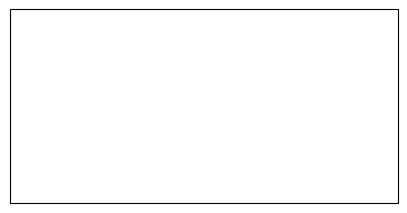

In [10]:
# mission_dates = np.unique(atomic_wsra['day'])

# for date in mission_dates[0:2]:
#     atomic_wsra_in_mission = atomic_wsra.where(atomic_wsra['day'] == date)
#     for swift_id in atomic_swifts.keys():
#         atomic_swift_in_mission = atomic_swifts[swift_id].where(atomic_swifts[swift_id]['day'] == date)

#         wsra_indices = matching_wsra_indices[swift_id]
#         swift_indices = matching_swift_indices[swift_id]

#         atomic_wsra_matches = atomic_wsra_in_mission.isel(time=wsra_indices)
#         ax = atomic_wsra_in_mission.isel(time=wsra_indices).wsra.plot(plot_best_track=False)
#         ax.scatter(atomic_swift_in_mission.isel(time=swift_indices)['lon'],
#                    atomic_swift_in_mission.isel(time=swift_indices)['lat'],
#                    s=5)

In [15]:
def plot_swift(ax, swift_ds, var, **scatter_kwargs):
    ax.scatter(
        swift_ds['lon'],
        swift_ds['lat'],
        c=swift_ds[var],
        **scatter_kwargs
)

def plot_wsra(ax, cax, wsra_ds, var, **plot_kwargs):
    wsra_ds.wsra.plot(
        ax=ax,
        cax=cax,
        column=var,
        **plot_kwargs
    )


def comparison_plot(ax, wsra_ds, swift_ds, wsra_var, swift_var, **scatter_kwargs):
    #TODO: color by prox using c?
    ax.scatter(
        wsra_ds[wsra_var],
        swift_ds[swift_var],
        **scatter_kwargs
    )


In [12]:
def create_figure():
    fig = plt.figure(figsize=(12, 6))
    gs = mpl.gridspec.GridSpec(1, 2, width_ratios=[2.5, 1], wspace = .35)
    ax1 = fig.add_subplot(gs[0], projection=PROJECTION)
    ax2 = fig.add_subplot(gs[1])

    divider = make_axes_locatable(ax1)
    cax = divider.append_axes("right", size="5%", axes_class=mpl.axes.Axes, pad="2%")

    return fig, ax1, ax2, cax

In [107]:
mission_dates = np.unique(atomic_wsra['day'])


matches_dict = []
for date in mission_dates:

    wsra_in_mission = atomic_wsra.where(atomic_wsra['day'] == date, drop=True)

    for swift_id in atomic_swifts.keys():
        match_dict = {}
        swift_in_mission = atomic_swifts[swift_id].where(atomic_swifts[swift_id]['day'] == date)

        wsra_indices, swift_indices = colocate_with_path(
            wsra_ds = wsra_in_mission,
            path_ds = swift_in_mission,
            path_vars = ('time', 'lat', 'lon', ''),
            wsra_vars = ('time', 'latitude', 'longitude'),
            temporal_tolerance = np.timedelta64(60, 'm'),
            spatial_tolerance = 55,  #km
        )
        match_dict['date'] = date
        match_dict['swift_id'] = swift_id
        match_dict['wsra_indices'] = wsra_indices
        match_dict['swift_indices'] = swift_indices
        matches_dict.append(match_dict)

matches_df = (pd.DataFrame(matches_dict)
    .dropna()
    .set_index(['date', 'swift_id'])
)


KeyError: numpy.datetime64('NaT')

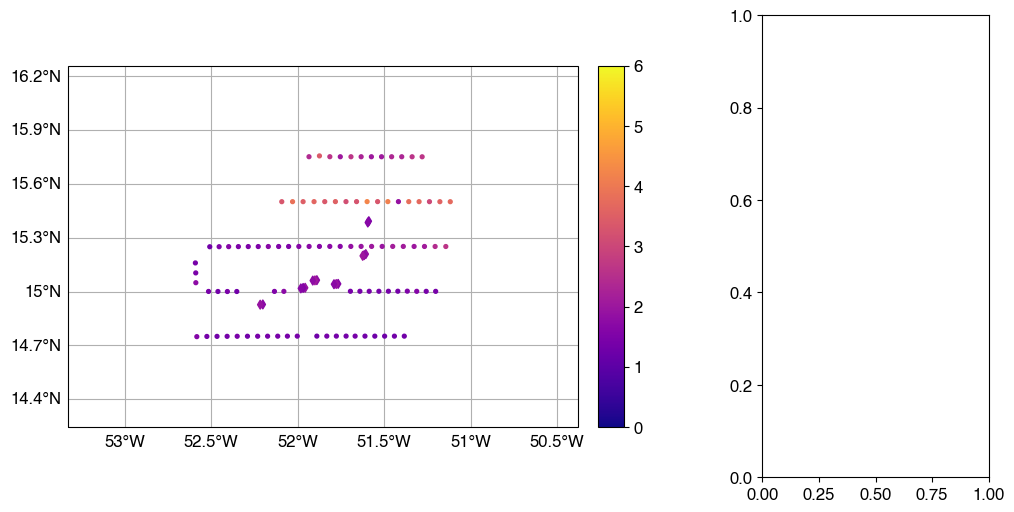

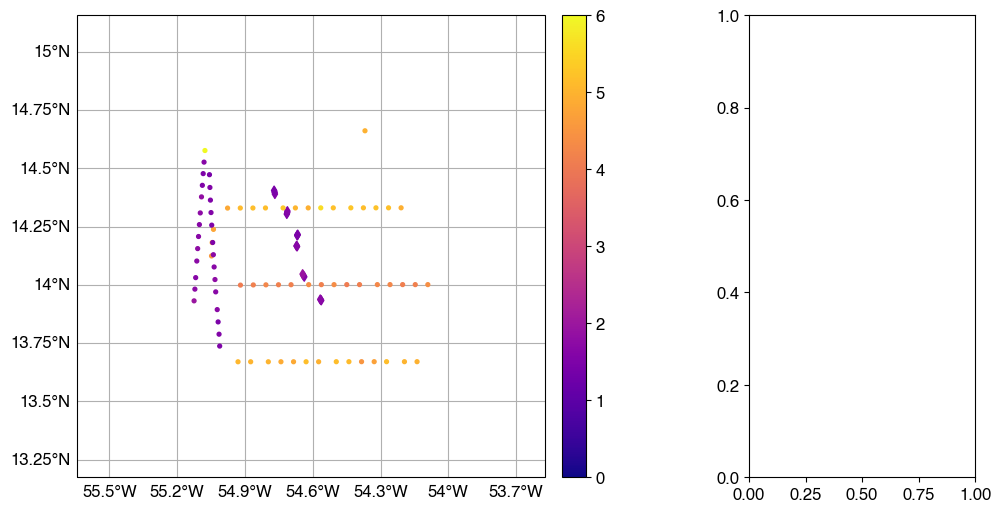

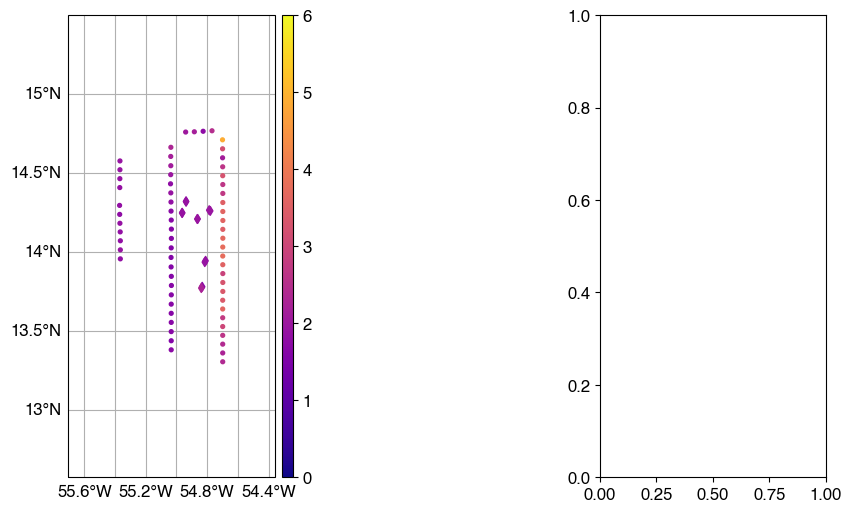

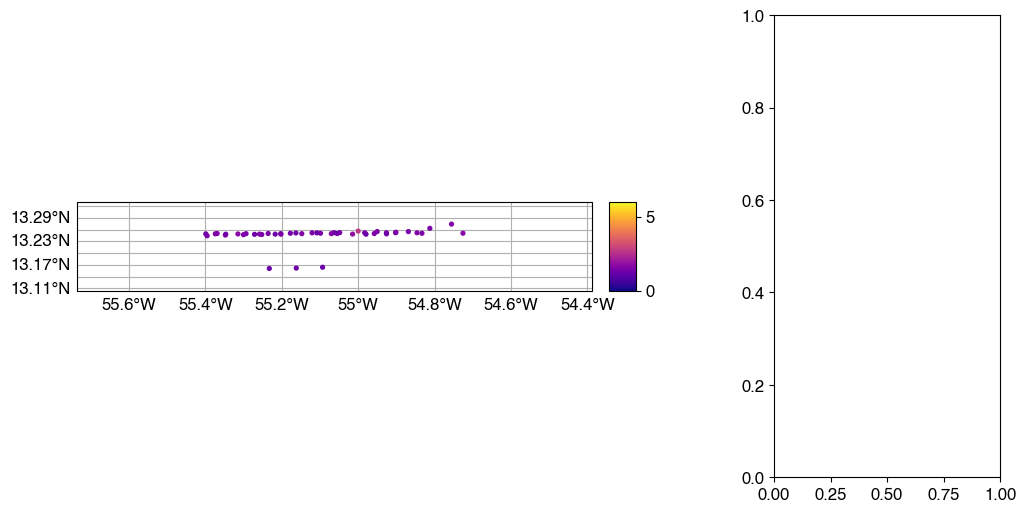

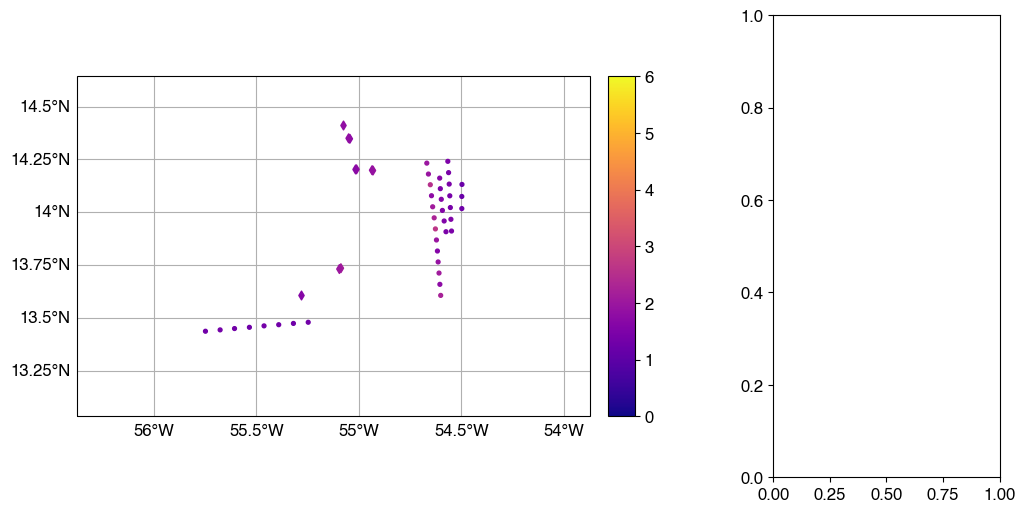

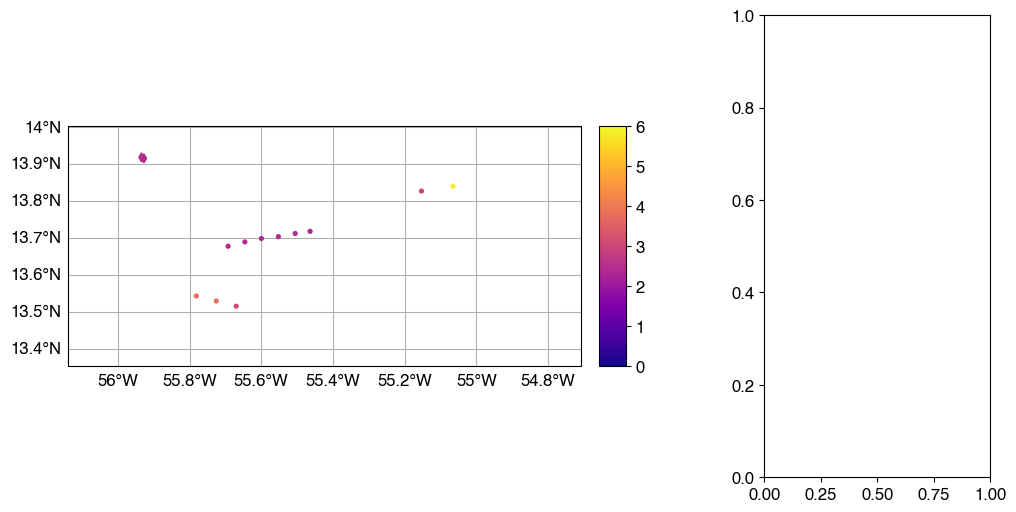

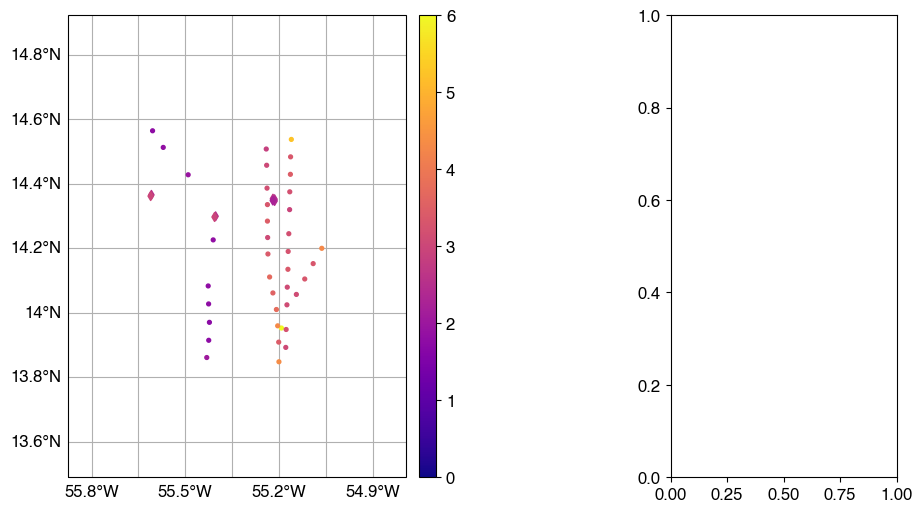

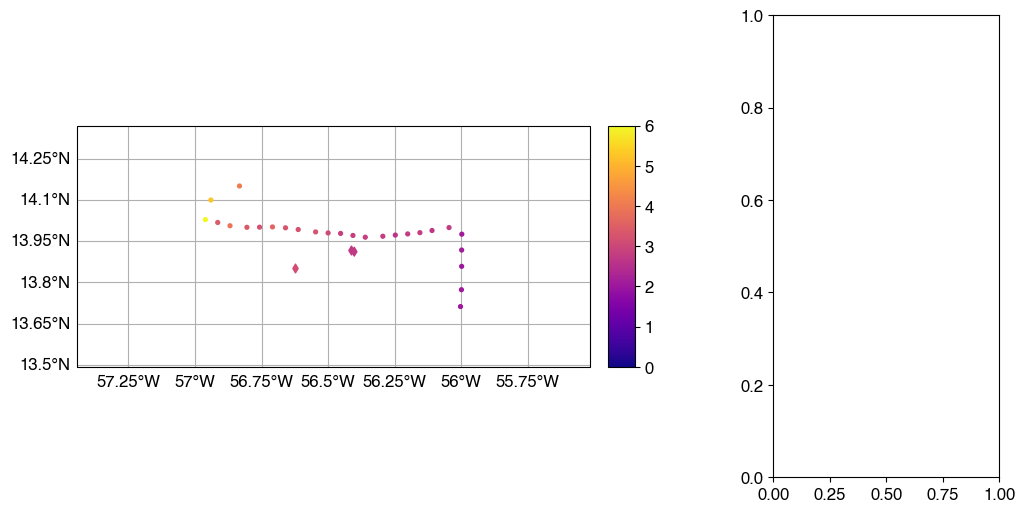

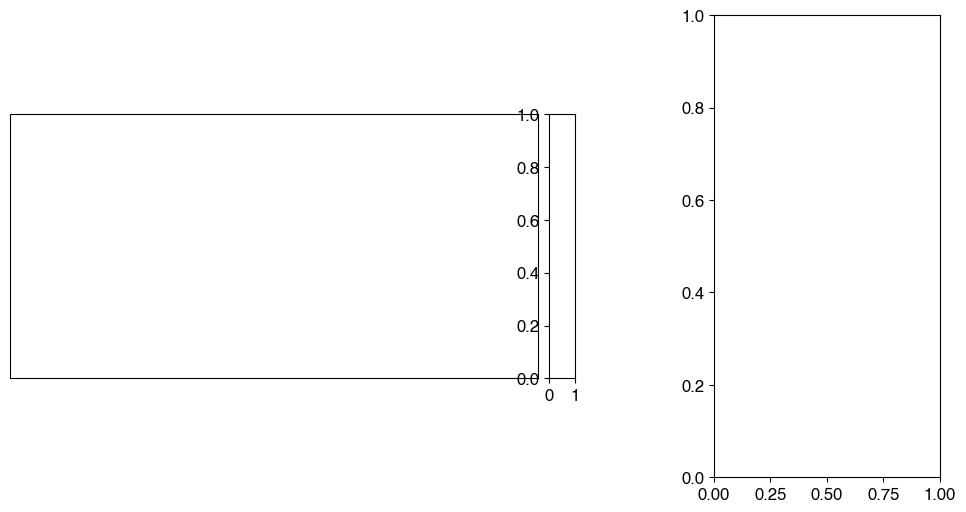

In [126]:
wsra_var='sea_surface_wave_significant_height'
swift_var='sea_surface_wave_significant_height'
cmap=mpl.cm.plasma
norm=mpl.colors.Normalize(vmin=0, vmax=6)

PROJECTION = cartopy.crs.PlateCarree()
IMAGE_RESOLUTION = 300
SWIFT_SCATTER_KWARGS = dict(
    s=20,
    marker='d',
    label='SWIFT',
    cmap=cmap,
    norm=norm,
)
WSRA_PLOT_KWARGS = dict(
    legend=True,
    marker='.',
    markersize=30,
    label='WSRA',
    plot_best_track=False,
    cmap=cmap,
    norm=norm,
    legend_kwds={
        "orientation": "vertical",
        "location": "right",
    }
)

mission_dates = np.unique(atomic_wsra['day'])

for date in mission_dates:

    hs_fig, hs_ax1, hs_ax2, hs_cax = create_figure()

    wsra_in_mission = atomic_wsra.where(atomic_wsra['day'] == date, drop=True)
    all_wsra_indices = []
    for swift_id in atomic_swifts.keys():
        swift_in_mission = atomic_swifts[swift_id].where(atomic_swifts[swift_id]['day'] == date)

        wsra_indices, swift_indices = colocate_with_path(
            wsra_ds = wsra_in_mission,
            path_ds = swift_in_mission,
            path_vars = ('time', 'lat', 'lon', ''),
            wsra_vars = ('time', 'latitude', 'longitude'),
            temporal_tolerance = np.timedelta64(60, 'm'),
            spatial_tolerance = 55,  #km
        )

        all_wsra_indices.append(wsra_indices)
        swift_matches = swift_in_mission.isel(time=np.unique(swift_indices))

        plot_swift(hs_ax1, swift_matches, swift_var, **SWIFT_SCATTER_KWARGS)


    unique_wsra_indices = np.unique(np.concatenate(all_wsra_indices))

    if unique_wsra_indices.size > 0:
        wsra_matches = wsra_in_mission.isel(time=unique_wsra_indices)
        wsra_matches.wsra.chart.ocean_color = 'white' # 'whitesmoke'
        wsra_matches.wsra.chart.land_color = 'floralwhite'  # white, whitesmoke
        wsra_matches.wsra.chart.buffer_percent=0.5
        plot_wsra(hs_ax1, hs_cax, wsra_matches, wsra_var, **WSRA_PLOT_KWARGS)
        #TODO: need all swifts! Maybe compile a dict instead?
        # comparison_plot(hs_ax2, wsra_matches, swift_matches, wsra_var, swift_var, color='k', s=5)

    else:
        plt.close()

In [116]:
swift_id

'SWIFT22'

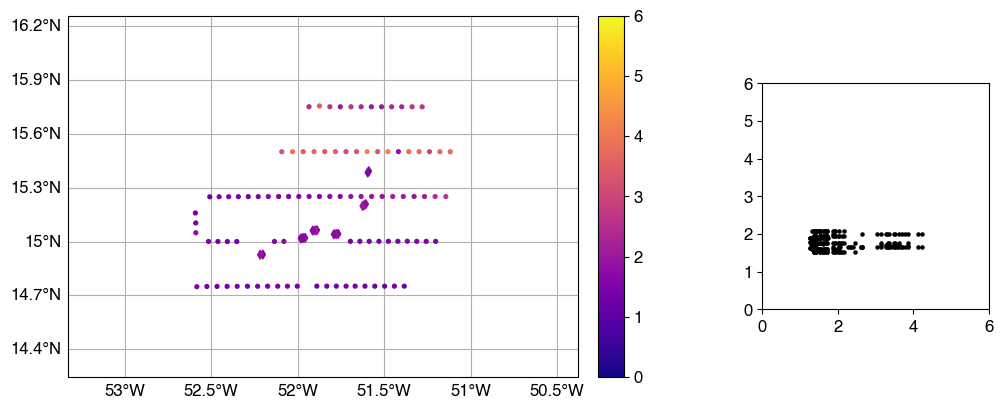

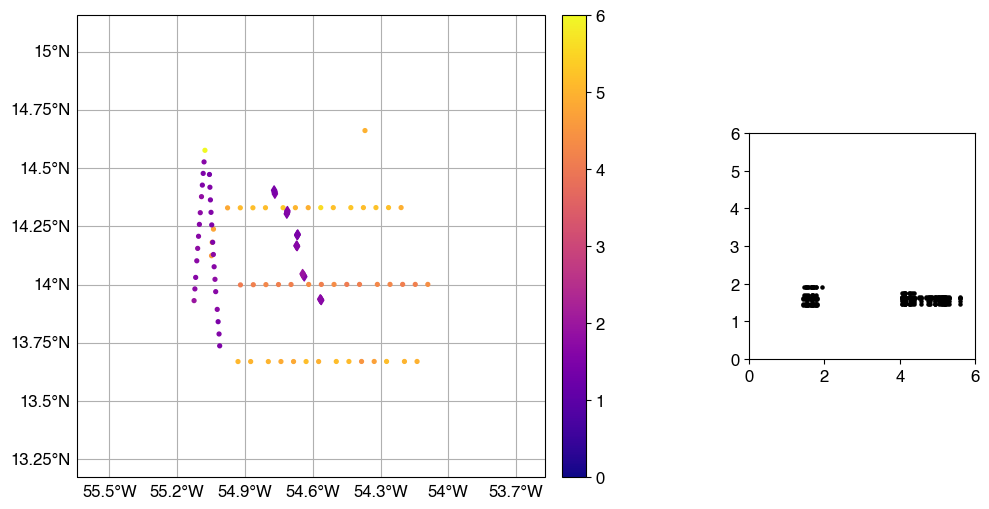

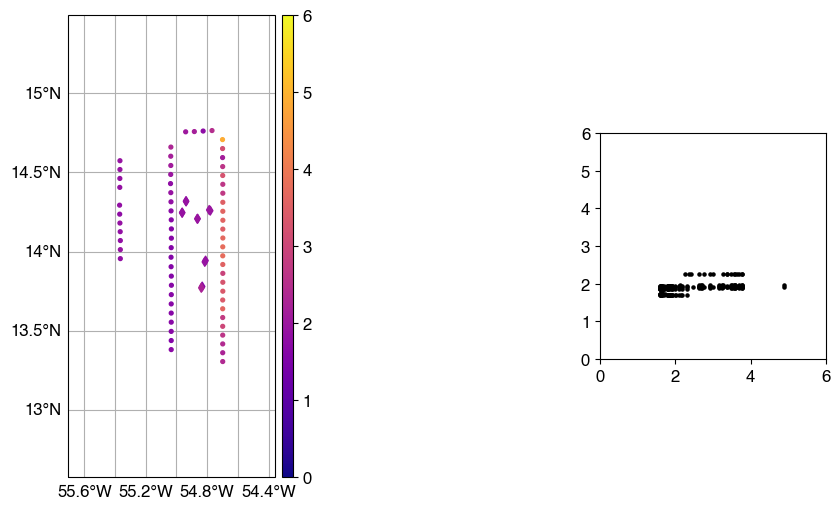

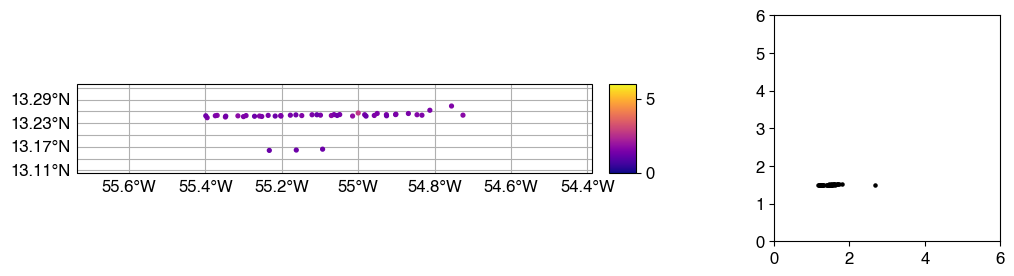

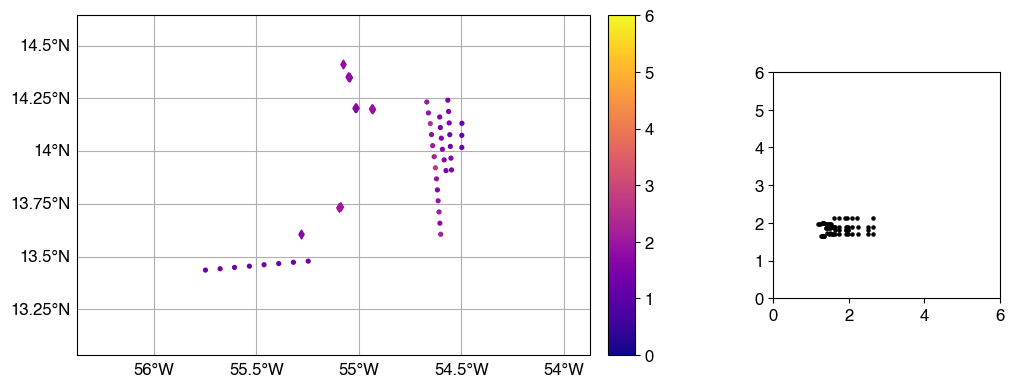

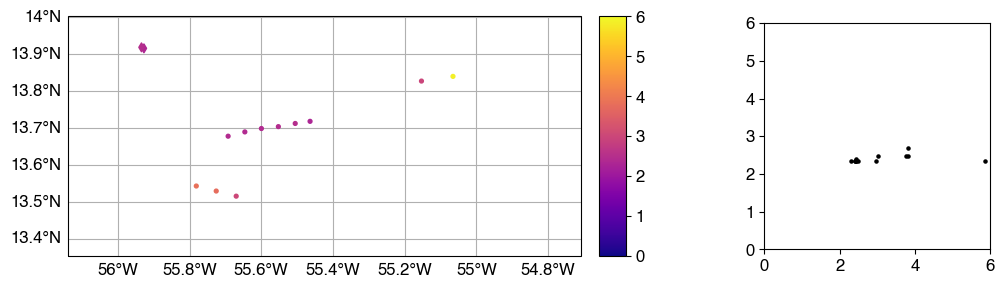

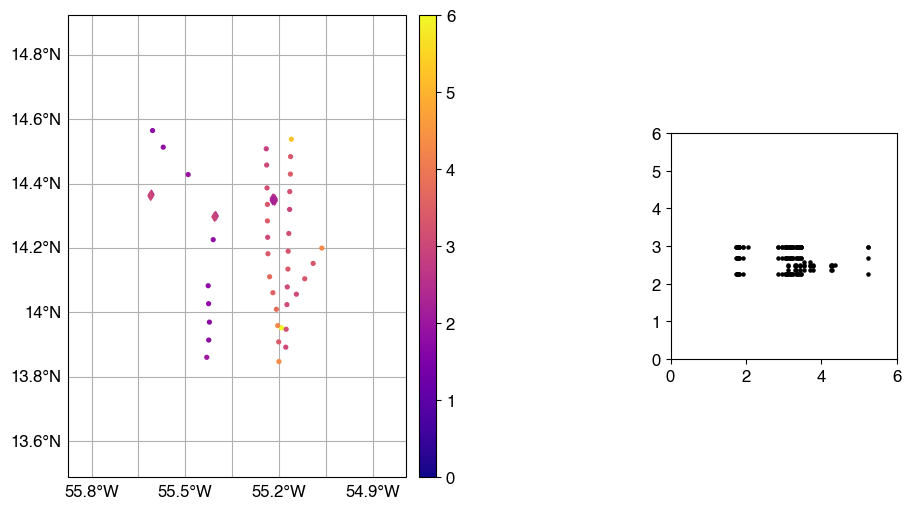

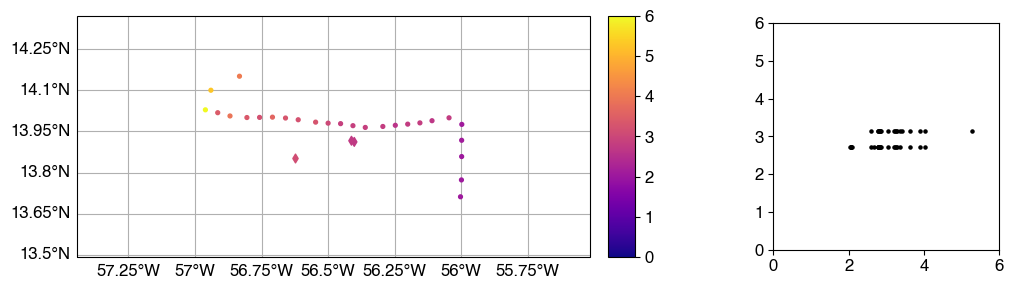

In [134]:
wsra_var='sea_surface_wave_significant_height'
swift_var='sea_surface_wave_significant_height'
cmap=mpl.cm.plasma
norm=mpl.colors.Normalize(vmin=0, vmax=6)

PROJECTION = cartopy.crs.PlateCarree()
IMAGE_RESOLUTION = 300
SWIFT_SCATTER_KWARGS = dict(
    s=20,
    marker='d',
    label='SWIFT',
    cmap=cmap,
    norm=norm,
)
WSRA_PLOT_KWARGS = dict(
    legend=True,
    marker='.',
    markersize=30,
    label='WSRA',
    plot_best_track=False,
    cmap=cmap,
    norm=norm,
    legend_kwds={
        "orientation": "vertical",
        "location": "right",
    }
)

mission_dates = np.unique(atomic_wsra['day'].dropna(dim='time'))

for date in mission_dates:

    unique_wsra_indices = np.unique(np.concatenate(matches_df.loc[date]['wsra_indices'].to_numpy()))

    if unique_wsra_indices.size > 0:

        hs_fig, hs_ax1, hs_ax2, hs_cax = create_figure()

        wsra_in_mission = atomic_wsra.where(atomic_wsra['day'] == date, drop=True)
        wsra_matches_unique = wsra_in_mission.isel(time=unique_wsra_indices)
        wsra_matches_unique.wsra.chart.ocean_color = 'white' # 'whitesmoke'
        wsra_matches_unique.wsra.chart.land_color = 'floralwhite'  # white, whitesmoke
        wsra_matches_unique.wsra.chart.buffer_percent=0.5
        plot_wsra(hs_ax1, hs_cax, wsra_matches_unique, wsra_var, **WSRA_PLOT_KWARGS)
        #TODO: need all swifts! Maybe compile a dict instead?
        # comparison_plot(hs_ax2, wsra_matches, swift_matches, wsra_var, swift_var, color='k', s=5)

        for swift_id in atomic_swifts.keys():
            swift_in_mission = atomic_swifts[swift_id].where(atomic_swifts[swift_id]['day'] == date)

            wsra_indices = matches_df.loc[date].loc[swift_id]['wsra_indices']
            swift_indices = matches_df.loc[date].loc[swift_id]['swift_indices']
            wsra_matches = wsra_in_mission.isel(time=wsra_indices)
            swift_matches = swift_in_mission.isel(time=swift_indices)
            swift_matches_unique = swift_in_mission.isel(time=np.unique(swift_indices))
            plot_swift(hs_ax1, swift_matches_unique, swift_var, **SWIFT_SCATTER_KWARGS)
            comparison_plot(hs_ax2, wsra_matches, swift_matches, wsra_var, swift_var, color='k', s=5)

        hs_ax2.set_aspect('equal')
        hs_ax2.set_ylim([0, 6])
        hs_ax2.set_xlim([0, 6])

